# DCSI 525 Milestone 1 _ group 1

Contributors:
- Jacob McFarlane
- Sang Yoon Lee
- Sukhdeep Kaur
- Yiki Su

## Step 0 - Import dependencies and set directory

In [1]:
import re
import os
import glob
import zipfile
import requests
import matplotlib
import json
import pandas as pd
from urllib.request import urlretrieve
from memory_profiler import memory_usage
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow.parquet as pq
import rpy2.rinterface
import rpy2_arrow.pyarrow_rarrow as pyra
import pyarrow.feather as feather

In [2]:
%load_ext rpy2.ipython
%load_ext memory_profiler

C:\Users\Sang\miniconda3\envs\525\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%pwd

'C:\\Users\\Sang\\aus_rain_cloud'

In [4]:
%cd /Users/Sang/

C:\Users\Sang


## Step 1 - Downloading the data

In [5]:
article_id = 14096681 
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareairline/"

In [6]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]             
files

[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

In [7]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

Wall time: 1min 4s


In [8]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

Wall time: 23.6 s


## Step 2 - Combining the csvs

In [9]:
%%time
%memit

import pandas as pd
files = glob.glob('figshareairline/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0).assign(model=re.findall(r'^.*?(?=_)', os.path.basename(file))[0])
                for file in files))

df.to_csv("figshareairline/combined_data.csv")

peak memory: 282.98 MiB, increment: 0.24 MiB
Wall time: 9min 12s


>The comparison of run times and memory usages on different machine.
>
|OS|RAM|Time|Memory usages|
|:--:|:---:|:---:|:---:|
|Mac|8 Gb| 6 mins 46 s|peak memory: 1692 MiB<br> increment: 69.48 MiB|
|Windows 10 professional|8 Gb| system crashed while combining the csv|system crashed while combining the csv|
|Windows 10 professional|16 Gb| 10 mins|peak memory: 82.52 MiB<br> increment: 0.82 MiB|
|Windows 10 professional|16 Gb| 7min 45s|peak memory: 279.80 MiB<br> increment: 0.01 MiB|

## Step 3 - Loading and EDA in Python

### EDA 1 - using pandas chunksize

In [85]:
%%time
%%memit
df = pd.read_csv("figshareairline/combined_data.csv")
print(df["model"].value_counts())

SAM0-UNICON    62513863
Name: model, dtype: int64
peak memory: 4356.98 MiB, increment: 1848.12 MiB
CPU times: user 1min 14s, sys: 34.6 s, total: 1min 48s
Wall time: 2min 9s


In [83]:
%%time
%%memit
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("figshareairline/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts)

SAM0-UNICON    62513863.0
dtype: float64
peak memory: 3048.96 MiB, increment: 416.56 MiB
CPU times: user 1min 5s, sys: 9.11 s, total: 1min 14s
Wall time: 1min 17s


>The comparison of run times and memory usages on different machine.
>
>|OS|RAM|Time|Memory usages|
|:--:|:---:|:---:|:---:|
|Mac|8 Gb| 1min 17s|peak memory: 3048.96 MiB<br> increment: 416.56 MiB|
|Windows 10 professional|16 Gb| 2min 3s|peak memory: 5162.25 MiB<br> increment: 0.58 MiB|
>
>Overall: In EDA1, we have observed in two machines that when we are reading the combined file in chunks as compared to reading the full file in one go using pandas, the time and memory usage are less when we are reading the file in chunks.

### EDA 2 - Changing dtype of the data using Pandas

In [10]:
%%time
print(f"Memory usage with float64: {df.memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df.astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 3500.78 MB
Memory usage with float32: 2250.50 MB
Wall time: 1.15 s


>The comparison of memory usages on different machine.
>
>|OS|RAM|Memory usages(float32)|Memory usages(float64)|
|:--:|:---:|:---:|:---:|
|Mac|8 Gb| 3048.96 MB|2250.50 MB|
|Windows 10 professional|16 Gb|3048.96 MB|2250.50 MB|
>
>Overall: In EDA2, we have observed in two machines that when we are are changing the datatypes to float32 from float64, the system takes less memory.

### EDA 3 - Using specific columns

In [11]:
%%time
%%memit
usecols =  ['time', 'rain (mm/day)', 'model']
#simple pandas - This is how we do normally ,which means we are loading the entire data to the memory
df = pd.read_csv("figshareairline/combined_data.csv", usecols= usecols)
df.head(5)

peak memory: 8295.74 MiB, increment: 4569.64 MiB
Wall time: 53.1 s


>The comparison of run times and memory usages on different machine.
>
>|OS|RAM|Time|Memory usages|
|:--:|:---:|:---:|:---:|
|Mac|8 Gb| 3min 55s|peak memory: 2852.70 MiB<br> increment: 2707.99 MiB|
|Windows 10 professional|16 Gb| 1min 23s|peak memory: 9159.09 MiB<br> increment: 3812.83 MiB|
>
>Overall: In this EDA, we used few columns from the combined file and observed that the memory usage is lower as compared to loading the file with all the columns.

In [19]:
#!pip install matplotlib

peak memory: 4737.94 MiB, increment: 1300.15 MiB
Wall time: 43.2 s


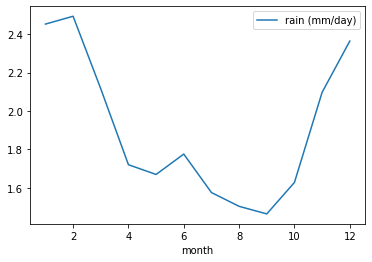

In [12]:
%%time
%%memit
climate_data = df
climate_data['time'] = pd.to_datetime(climate_data['time'])
climate_data['month'] = climate_data.time.dt.month
climate_data.groupby("month").mean('rainfall (mm/day)')[['rain (mm/day)']].plot()

> Findings from plot above.
>- On Average, Rainfall Seems to be lowest in Australia during the Austral Autumn and Winter.
>- Most days in australia have very little rainfall.

## Step 4 - EDA using R

In [5]:
%%R
# call library
library("arrow")
library("tidyverse")
library("dplyr")
library("lubridate")

R[write to console]: -- Attaching packages --------------------------------------- tidyverse 1.3.0 --

R[write to console]: <U+221A> ggplot2 3.3.3     <U+221A> purrr   0.3.4
<U+221A> tibble  3.0.5     <U+221A> dplyr   1.0.3
<U+221A> tidyr   1.1.2     <U+221A> stringr 1.4.0
<U+221A> readr   1.4.0     <U+221A> forcats 0.5.1

R[write to console]: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: 'lubridate'


R[write to console]: The following objects are masked from 'package:base':

    date, intersect, setdiff, union




### Create feather and parquet format

In [6]:
%%time
%%memit
dataset = ds.dataset("figshareairline/combined_data.csv", format="csv")
table = dataset.to_table()

peak memory: 4220.02 MiB, increment: 3878.14 MiB
Wall time: 35.7 s


In [15]:
%%time
%%memit
# create feather file
feather.write_feather(table, 'figshareairline/rain.feather')

peak memory: 6164.29 MiB, increment: 20.36 MiB
Wall time: 4.74 s


In [16]:
%%time
## writing as a single parquet 
pq.write_to_dataset(table, 'figshareairline/rain.parquet')

Wall time: 13.1 s


In [7]:
%%sh
# check the data size
du -sh figshareairline/combined_data.csv
du -sh figshareairline/rain.feather
du -sh figshareairline/rain.parquet

5.7G	figshareairline/combined_data.csv
1.1G	figshareairline/rain.feather
542M	figshareairline/rain.parquet


### EAD1 - use various file format

In [7]:
%%time
%%memit
# loading the arrow dataframe
rain_table = pyra.converter.py2rpy(table)

5756
rarrow.ChunkedArray: 0.04695248603820801
5756
rarrow.ChunkedArray: 0.08302617073059082
5756
rarrow.ChunkedArray: 0.04500317573547363
5756
rarrow.ChunkedArray: 0.04104423522949219
5756
rarrow.ChunkedArray: 0.042853355407714844
5756
rarrow.ChunkedArray: 0.03500056266784668
5756
rarrow.ChunkedArray: 0.03400850296020508
peak memory: 4291.91 MiB, increment: 76.25 MiB
Wall time: 38.9 s


In [9]:
%%time
%%R -i rain_table
start_time <- Sys.time()
result_arrow <- rain_table %>% collect() %>% count(model)
print(class(rain_table %>% collect()))
end_time <- Sys.time()
print(result_arrow)
print(end_time - start_time)

[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 28 x 2
   model                  n
 * <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# ... with 18 more rows
Time difference of 24.34746 secs
Wall time: 24.7 s


In [ ]:
### Note: Even feature has samller file size than csv file, the system crushed while loading feather file. 
### Due to crush issues, the code below is not able to run
# %%time
# %%R
# start_time <- Sys.time()
#rain_table_feather <- arrow::read_feather("figshareairline/rain.feather")   
# result_feather <- rain_table_feather %>% count(model)
# end_time <- Sys.time()
# print(result_feather)
# print(end_time - start_time)
  

In [ ]:
### Note: Even parquet has samller file size than csv file, the system crushed while loading parquet file. 
### Due to crush issues, the code below is not able to run
# %%time
# %%R
# start_time <- Sys.time()
#rain_table_parquet <- read_parquet("figshareairline/rain.parquet")  
# result_parquet <- rain_table_parquet %>% count(model)
# end_time <- Sys.time()
# print(result_parquet)
# print(end_time - start_time)

In [ ]:
### Note: The system crushed while perform EDA due to memory issues. 
### Due to out of memory issues, the code below is not able to run
# %%time
# %%R -i df
# start_time <- Sys.time()
# result_feather <- df %>% count(model)
# end_time <- Sys.time()
# print(result_df)
# print(end_time - start_time)

Time difference of 16.86664 secs


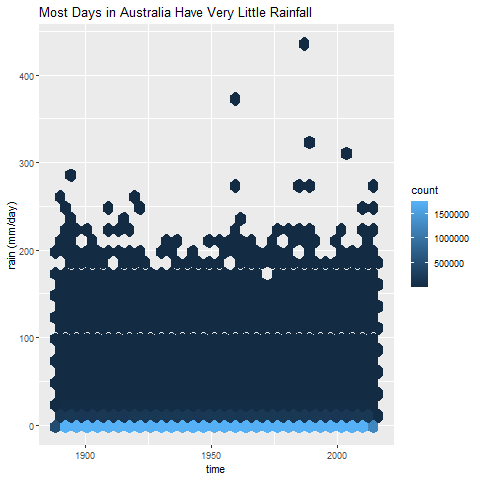

In [16]:
%%R -i rain_table
start_time <- Sys.time()
fig <- rain_table  %>% collect()  %>% ggplot(aes(x = time, y = `rain (mm/day)`)) +
  geom_hex() +
  ggtitle('Most Days in Australia Have Very Little Rainfall')
end_time <- Sys.time()
print(fig)
print(end_time - start_time)

Time difference of 2.386146 mins


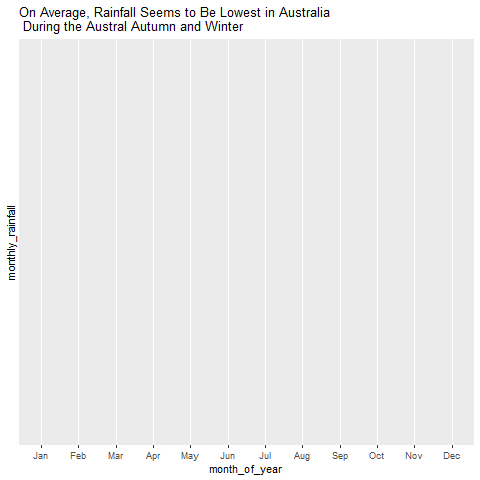

Wall time: 2min 23s


In [18]:
%%time
%%R -i rain_table
start_time <- Sys.time()
fig <- rain_table  %>% 
  collect() %>%
  mutate(month_of_year = month(time, label = TRUE)) %>%
  group_by(month_of_year) %>%
  summarise(monthly_rainfall = mean(`rain (mm/day)`)) %>%
  ggplot(aes(x = month_of_year, y = monthly_rainfall)) +
    geom_col() +
    ggtitle('On Average, Rainfall Seems to Be Lowest in Australia \n During the Austral Autumn and Winter')
end_time <- Sys.time()
print(fig)
print(end_time - start_time)

> Disscusions from R EDA
>- The reason choosing `Arrow exchange` is faster than other format in terms of reading and writing. It takes only 8.8s to 
>- `Pandas exchange` and `feather` occurs system crush while perform EDA.
>- The size of `feather` file is less than that of csv file but there was memory issue in local computer.
>- Other team members are not able to perform EDA with R because their local computer has problem with `%%R` magic.
>- The last graph return empthy graph becaues it seems that there are some issues when we write data on exist arrow table. 